<a href="https://colab.research.google.com/github/nourel25/MRI-images-Brain-tumor/blob/main/MRI_images_%7C%7C_Brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile

In [6]:
dataset = '/content/brain-mri-images-for-brain-tumor-detection.zip'

with zipfile.ZipFile(dataset, 'r') as zip_ref:
  zip_ref.extractall('data')

In [7]:
DATA_DIR = 'data/brain_tumor_dataset'

In [8]:
no_tumor = os.path.join(DATA_DIR, 'no')
yes_tumor = os.path.join(DATA_DIR, 'yes')

In [9]:
print(f'There are {len(os.listdir(no_tumor))} images of brain without tumor')
print(f'There are {len(os.listdir(yes_tumor))} images of brain with tumor ')

There are 98 images of brain without tumor
There are 155 images of brain with tumor 


In [10]:
train, val = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    label_mode = 'binary',
    batch_size=32,
    image_size=(150, 150),
    subset='both',
    validation_split=0.20,
    seed=42
)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Using 50 files for validation.


In [11]:
class_names = train.class_names
class_names

['no', 'yes']

/tmp/ipython-input-12-3165820637.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())


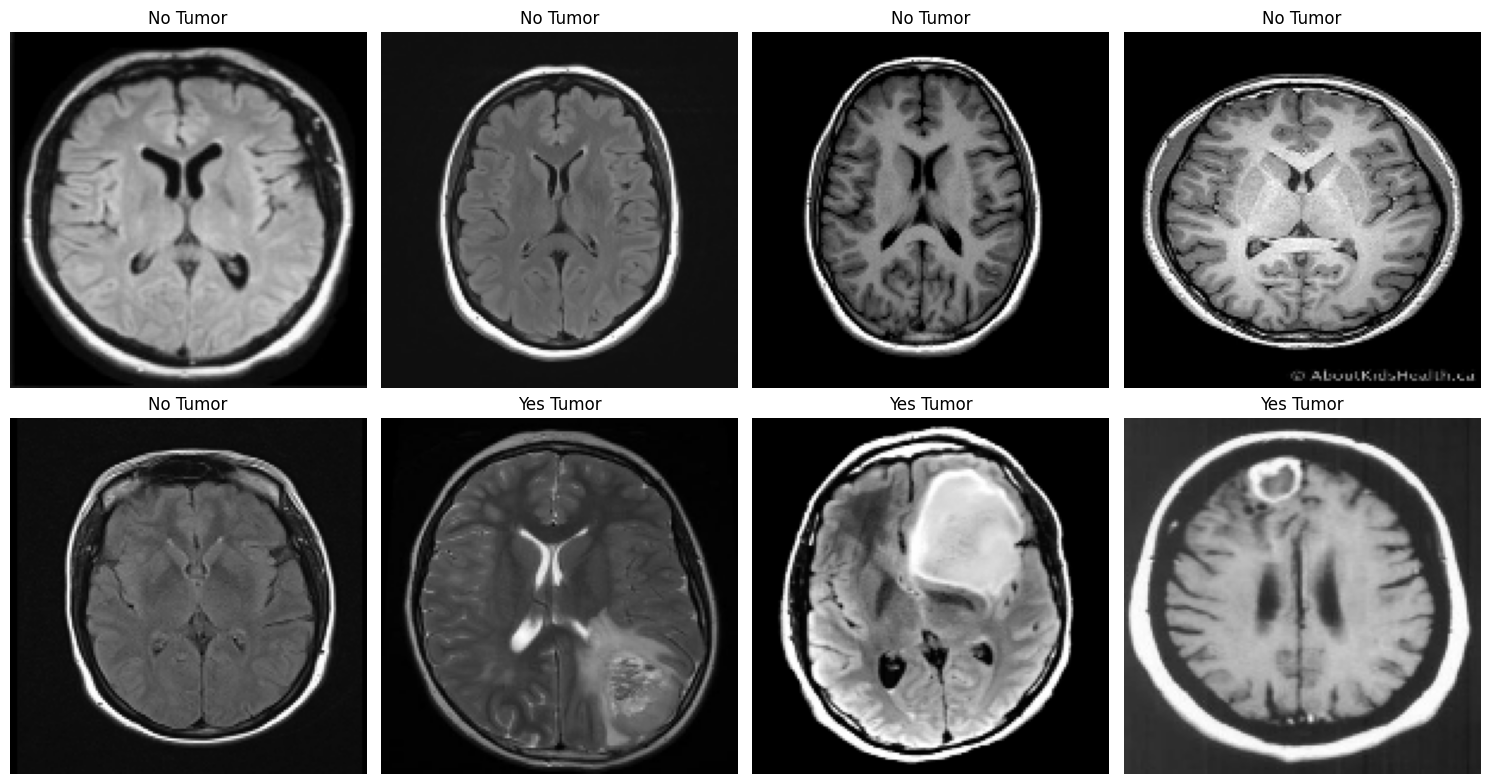

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.flatten()

for images, labels in train.take(1):
  for i in range(8):
    axes[i].imshow(images[i].numpy().astype('uint8'))

    label = int(labels[i].numpy())
    tumor_type = class_names[label].title()
    axes[i].set_title(f'{tumor_type} Tumor')

    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05, fill_mode='nearest'), # ±3°
    tf.keras.layers.RandomZoom(0.05, fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(0.03),
    tf.keras.layers.RandomContrast(0.03),
])

In [14]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_final = train.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
val_final = val.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [15]:
models = {
    'VGG16': tf.keras.applications.VGG16,
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'EfficientNetB3': tf.keras.applications.EfficientNetB3
}

results = {}

In [16]:
for model_name, base_fn in models.items():
  print(f"\n🔧 Training {model_name}")

  base_model = base_fn(
      include_top=False,
      input_shape=(150, 150, 3),
      weights='imagenet'
  )

  base_model.trainable = False


  print(f"{model_name} base model output shape:", base_model.output_shape)
  print('All layers Frozen')

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(150, 150, 3)),
      augmentation_layers,
      tf.keras.layers.Rescaling(1./255),

      base_model,

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-4),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  history = model.fit(
    train_final,
    epochs=5,
    validation_data=val_final
  )

  print('Fine-Tuning last few layers')

  base_model.trainable = True

  for layer in base_model.layers[:-30]:
    layer.trainable = False

  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-6),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  history_finetune = model.fit(
      train_final,
      validation_data=val_final,
      epochs=5,
  )

  results[model_name] = {
      'history': history,
      'finetune': history_finetune
  }


🔧 Training VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 base model output shape: (None, 4, 4, 512)
All layers Frozen
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.6589 - loss: 0.6203 - val_accuracy: 0.8200 - val_loss: 0.4951
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.7802 - loss: 0.4817 - val_accuracy: 0.8000 - val_loss: 0.4585
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.7837 - loss: 0.4459 - val_accuracy: 0.8400 - val_loss: 0.4397
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.8156 - loss: 0.3916 - val_accuracy: 0.8600 - val_loss: 0.4301
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 10s/step - accuracy: 0.8395 - loss: 0.4280 - val_accuracy: 0.8200 - val_loss: 0.3820
Fine-Tuning last few layers
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 176s 24s/step - accuracy: 0.8285 - loss: 0.3364 - val_accuracy: 0.8600 - val_loss: 0.3976
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 171s 27s/step - accuracy: 0.8879 - loss: 0.3019 - val_accur

/tmp/ipython-input-16-1601076856.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_fn(


MobileNetV2 base model output shape: (None, 5, 5, 1280)
All layers Frozen
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5861 - loss: 1.3745 - val_accuracy: 0.8400 - val_loss: 0.4347
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 880ms/step - accuracy: 0.8131 - loss: 0.4738 - val_accuracy: 0.7400 - val_loss: 1.1136
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 801ms/step - accuracy: 0.7846 - loss: 0.5273 - val_accuracy: 0.8600 - val_loss: 0.3471
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 716ms/step - accuracy: 0.9159 - loss: 0.1959 - val_accuracy: 0.7800 - val_loss: 0.6318
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 893ms/step - accuracy: 0.9262 - loss: 0.1771 - val_accuracy: 0.8600 - val_loss: 0.3552
Fine-Tuning last few layers
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8467 - loss: 0.4443 - val_accuracy: 0.8600 - val_loss: 0.3414
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 862ms/step - accuracy: 0.8159 - loss: 0.4367 - val_accuracy: 0.8800 - val_loss: 0.3293
Epoch 3/5
7/7 ━━━━━━━━━━━

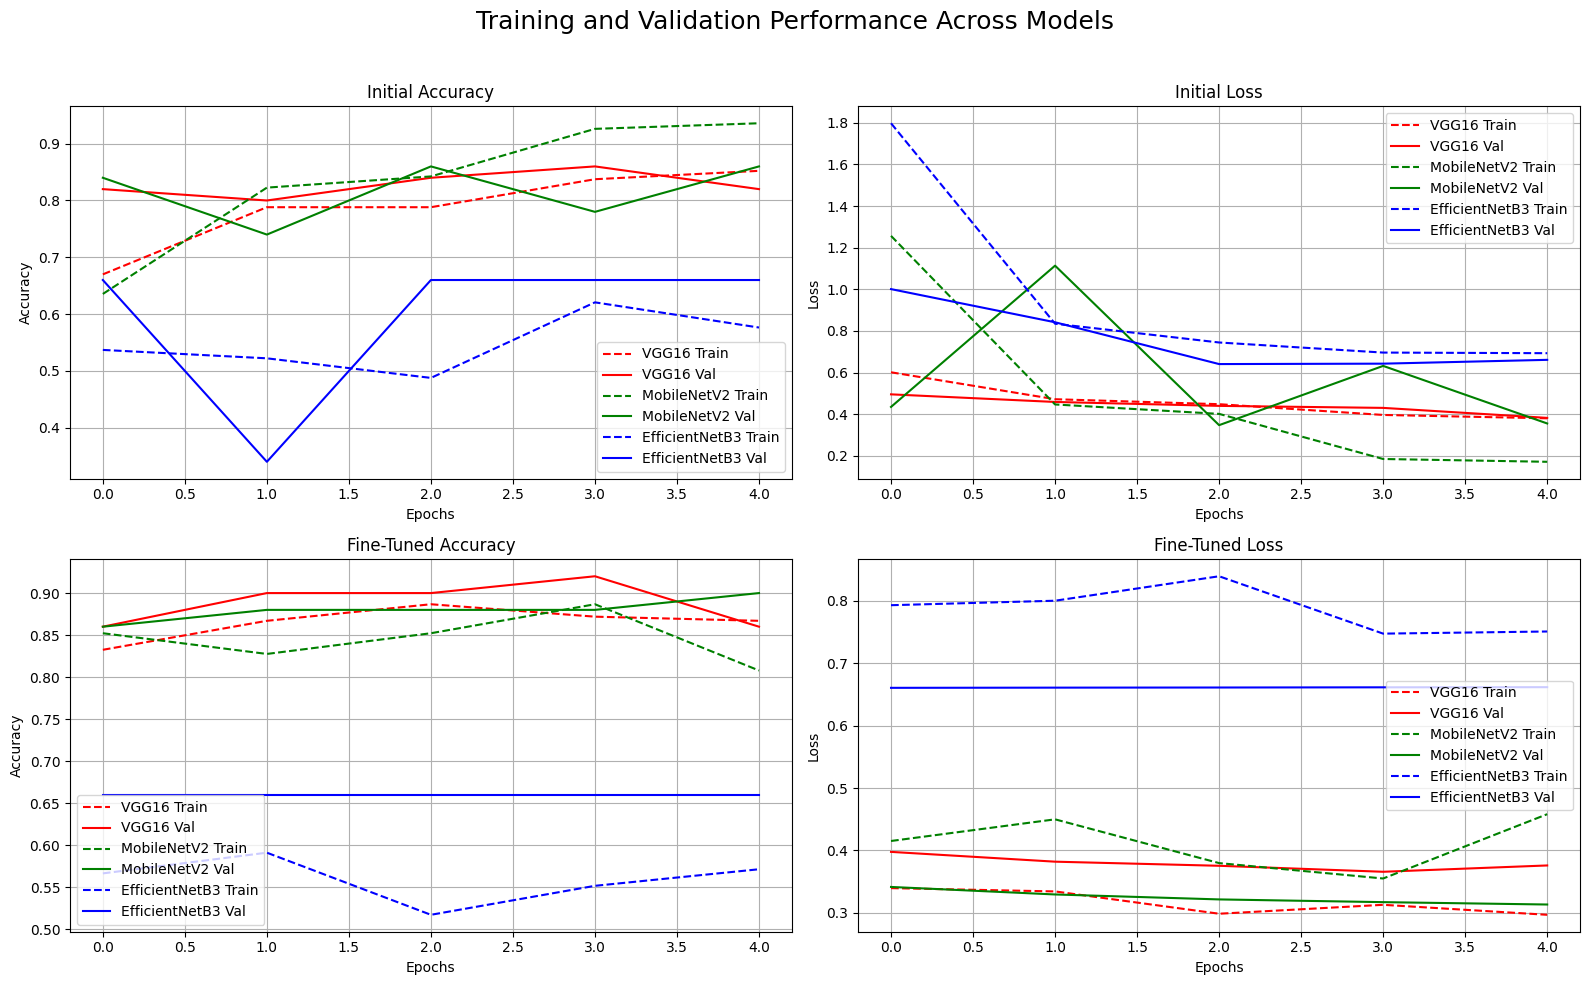

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Training and Validation Performance Across Models", fontsize=18)

colors = ['r', 'g', 'b', 'm', 'c', 'orange']

for i, (model_name, histories) in enumerate(results.items()):
    history = histories['history']
    finetune = histories['finetune']
    color = colors[i % len(colors)]

    # --- Initial Training ---
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    ax[0, 0].plot(epochs, acc, linestyle='--', color=color, label=f"{model_name} Train")
    ax[0, 0].plot(epochs, val_acc, linestyle='-', color=color, label=f"{model_name} Val")
    ax[0, 0].set_title("Initial Accuracy")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 0].legend()
    ax[0, 0].grid(True)

    ax[0, 1].plot(epochs, loss, linestyle='--', color=color, label=f"{model_name} Train")
    ax[0, 1].plot(epochs, val_loss, linestyle='-', color=color, label=f"{model_name} Val")
    ax[0, 1].set_title("Initial Loss")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Loss")
    ax[0, 1].legend()
    ax[0, 1].grid(True)

    # --- Fine-Tuning ---
    ft_acc = finetune.history['accuracy']
    ft_val_acc = finetune.history['val_accuracy']
    ft_loss = finetune.history['loss']
    ft_val_loss = finetune.history['val_loss']
    ft_epochs = range(len(ft_acc))

    ax[1, 0].plot(ft_epochs, ft_acc, linestyle='--', color=color, label=f"{model_name} Train")
    ax[1, 0].plot(ft_epochs, ft_val_acc, linestyle='-', color=color, label=f"{model_name} Val")
    ax[1, 0].set_title("Fine-Tuned Accuracy")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 0].set_ylabel("Accuracy")
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    ax[1, 1].plot(ft_epochs, ft_loss, linestyle='--', color=color, label=f"{model_name} Train")
    ax[1, 1].plot(ft_epochs, ft_val_loss, linestyle='-', color=color, label=f"{model_name} Val")
    ax[1, 1].set_title("Fine-Tuned Loss")
    ax[1, 1].set_xlabel("Epochs")
    ax[1, 1].set_ylabel("Loss")
    ax[1, 1].legend()
    ax[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()
